### Geospatial Data Analysis and Visualization in Python

A brief tutorial on using python packages to load and analyze three different geospatial data formats: netCDF, shapefile and geotiff.

#### Loading needed packages

In [2]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent ## geotiff plotting
import xarray as xr

import matplotlib.pyplot as plt

## ignore warning
import warnings
warnings.filterwarnings('ignore')
import glob

#### Load CA and USA boundary

In [4]:
## ca shapefile
datapath = 'data/CA_Counties'
ca = gpd.read_file(datapath).to_crs(epsg=4326)

## us shapefile
datapath = 'data/states_21basic'
us = gpd.read_file(datapath).to_crs(epsg=4326)
usa = us[(us['STATE_NAME'] != 'Hawaii') & (us['STATE_NAME'] != 'Alaska')]

## NetCDF

In [46]:
## example data
nc_file = '../fire-proj/scimap/data/netCDF/fm100_2010.nc'

Loading nc file with xarray (details see http://xarray.pydata.org/en/stable/quick-overview.html)

There are many different ways. Here's one I perfer:

In [47]:
## If your data has only one variable per file, use xr.open_dataarray(nc_file) is more convenient

with xr.open_dataset(nc_file) as ff:
    nc_ds = ff.load()
# nc_ds = xr.open_dataset(nc_file)

What information does a netCDF file include? The most of the datasets in this format we used here are weather data such as wind speed, temperature, humidity, etc.

In particular, in this dataset (gridMET http://www.climatologylab.org/gridmet.html ), each file has only one variable. Generally, one netCDF can have many variables

In [9]:
nc_ds

<xarray.Dataset>
Dimensions:                   (crs: 1, day: 365, lat: 585, lon: 1386)
Coordinates:
  * lon                       (lon) float64 -124.8 -124.7 ... -67.1 -67.06
  * lat                       (lat) float64 49.4 49.36 49.32 ... 25.11 25.07
  * day                       (day) datetime64[ns] 2010-01-01 ... 2010-12-31
  * crs                       (crs) uint16 3
Data variables:
    dead_fuel_moisture_100hr  (day, lat, lon) float32 nan nan nan ... nan nan
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial_lat_units:       decimal_degrees north


In [20]:
## shape of variable dead_fuel_moisture_100hr (day, lat, lon)
nc_ds.dead_fuel_moisture_100hr.shape

(365, 585, 1386)

In [18]:
## getting lat (lon, day, dead_fuel_moisture_100hr)
lat = nc_ds.lat.data
lat_name = nc_ds.lat.name
dead_fuel_moisture_100hr = nc_ds.dead_fuel_moisture_100hr.data  # including many nan values

This file includes lat, lon, day, crs (EPSG:4326) and dead_fuel_moisture_100hr.

lat, lon, day are coordinates and dead_fuel_moisture_100hr is variable, which means you can select dead_fuel_moisture_100hr by day, lat, lon.

For example:


In [38]:
## selecting, get variable dead_fuel_moisture_100hr on the second day
# http://xarray.pydata.org/en/stable/indexing.html
v_selected = nc_ds.isel(day=2)
v_selected

<xarray.Dataset>
Dimensions:                   (crs: 1, lat: 585, lon: 1386)
Coordinates:
  * lon                       (lon) float64 -124.8 -124.7 ... -67.1 -67.06
  * lat                       (lat) float64 49.4 49.36 49.32 ... 25.11 25.07
    day                       datetime64[ns] 2010-01-03
  * crs                       (crs) uint16 3
Data variables:
    dead_fuel_moisture_100hr  (lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial_lat_units:       decimal_degrees north
    geospatial_lon_units:   

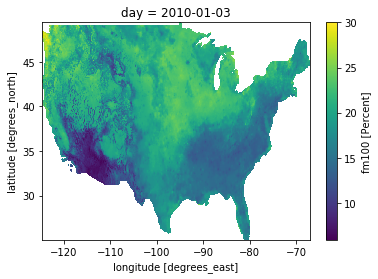

In [24]:
## visualize it
v_selected.dead_fuel_moisture_100hr.plot()

In [27]:
## selecting again by the index of lat (10 to 200) and lon (300 to 800)
v_selected_again = v_selected.isel(lat=slice(10, 200), lon=slice(300, 800))
v_selected_again

<xarray.Dataset>
Dimensions:                   (crs: 1, lat: 190, lon: 500)
Coordinates:
  * lon                       (lon) float64 -112.3 -112.2 ... -91.52 -91.47
  * lat                       (lat) float64 48.98 48.94 48.9 ... 41.15 41.11
    day                       datetime64[ns] 2010-01-03
  * crs                       (crs) uint16 3
Data variables:
    dead_fuel_moisture_100hr  (lat, lon) float32 19.9 20.1 ... 23.300001 23.5
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial_lat_units:       decimal_degrees north
    geospatial_lon_units:      

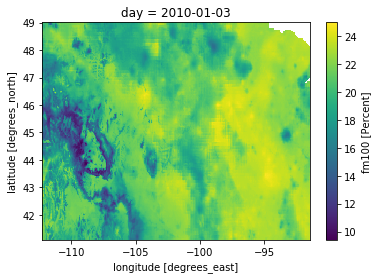

In [28]:
## visualizing it
v_selected_again.dead_fuel_moisture_100hr.plot()

You can also select with real data with .sel()

In [36]:
v_select_by_data = nc_ds.sel(day='2010-01-03', lon=slice(-112.3, -91.47),
                              lat=slice(48.99, 41.10))
v_select_by_data ## the same with the one above

<xarray.Dataset>
Dimensions:                   (crs: 1, lat: 190, lon: 500)
Coordinates:
  * lon                       (lon) float64 -112.3 -112.2 ... -91.52 -91.47
  * lat                       (lat) float64 48.98 48.94 48.9 ... 41.15 41.11
    day                       datetime64[ns] 2010-01-03
  * crs                       (crs) uint16 3
Data variables:
    dead_fuel_moisture_100hr  (lat, lon) float32 19.9 20.1 ... 23.300001 23.5
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial_lat_units:       decimal_degrees north
    geospatial_lon_units:      

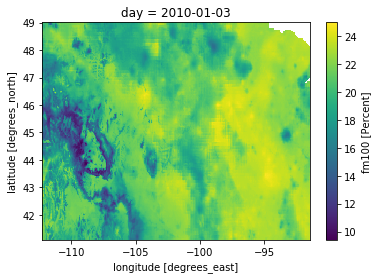

In [37]:
v_select_by_data.dead_fuel_moisture_100hr.plot()

### netCDF resample and clip by shapefile

In [1]:
def nc_resample_clip(nc_file, shp, target, out_dir=None):
    """
    clip netcdf with shpfile (shp) and resample to the same extent and resolution to the target
    input: nc_file, netcdf file name
        shp: shapefile used to clip
        target: target image
    output: save to disk or a dataset/dataarray
    """
    if 'salem' not in sys.modules:
        import salem
    
    name = nc_file.split('/')[-1]
    
    nc = xr.open_dataset(nc_file, chunks={'day': 12})
    
    ## clip
    nc_subset = nc.salem.subset(shape=shp)
    f_roi = nc_subset.salem.roi(shape=shp)
    
    ## resample
    f_resample = target.salem.transform(f_roi, interp='linear')
    f_final = f_resample.rename({'x': 'lon', 'y': 'lat'})
    affine = f.transform_from_latlon(f_final['lat'].data, f_final['lon'].data)
    f_final.attrs['res'] = (affine[0], -affine[4])
    nc.close()
    
    if out_dir != None:
#         comp = dict(dtype='int16', scale_factor=1.0, _FillValue=-9999)
#         encoding = {var: comp for var in f_final.data_vars}
        f_final.to_netcdf(os.path.join(out_dir, name))
    else:
        return f_final.data_vars

## Geotiff

### Image clipping, re-projection and resampling

<font color='red'>Annotations will be added later.</font> You can skip this part for now

In [39]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [48]:
## image re-rojection

def reproject_et(inpath, outpath, new_crs):
    
    dst_crs = new_crs # CRS for web meractor 

    with rio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)


In [2]:
def clip_geotiff(tiff, bound, out_file=None):
    """
    input: tiff, geotiff, not file
           box, list, e.g., [20, 30, 40, 50] [bottom, left, top, right]
           out_file: output file, e.g., 'data/file/out/out.tif'
    output: cropped geotiff 
    """
    import earthpy.spatial as es
    from shapely.geometry import box
    
    if (type(bound) == type([])):
        bbox = box(*bound)
    #     zoom_gpd = gpd.GeoDataFrame()
    #     zoom_gpd.loc[0, 'geometry'] = box(*zoomed_extent)
        zoom = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
    elif (type(bound) == type(MultiPolygon([]))):
        zoom = bound
    elif (type(bound) == type(Polygon())):
        zoom = MultiPolygon([bound])
    else:
        zoom = bound.geometry.unary_union
        if type(zoom) != type(MultiPolygon()):
            zoom = MultiPolygon([zoom])
    
    crop, crop_meta = es.crop_image(tiff, zoom)
    crop_affine = crop_meta['transform']
    extent = rio.plot.plotting_extent(crop[0], crop_affine)
    
    meta = tiff.meta.copy()
    meta.update({'transform': crop_affine,
                'height': crop.shape[1],
                'width': crop.shape[2]})
    if out_file != None:
        with rio.open(out_file, 'w', **meta) as ff:
            ff.write(crop)
    else:
        return {'data': crop, 'extent': extent}

In [4]:
## example of using clip_geotiff with shapefile 
geotiff_file = 'xxx/Global_fire_atlas_day_of_burn_yearly_2010.tif' ## not real

with rio.open(os.path.join(geotiff_file)) as ftif:
    out_f = 'xxx/xx.tif' ## output file
    clip_geotiff(ftif, ca, out_f)

In [83]:
def resampling_geotiff(tiff_file, scale=4, outdir=None):
    from rasterio.enums import Resampling
    
    with rio.open(tiff_file) as ff:
        data = ff.read(
            out_shape=(
                ff.count, 
                round(ff.width * scale), 
                round(ff.height * scale)
            ), 
            resampling=Resampling.bilinear,
            masked=True
        )
        transform = ff.transform * ff.transform.scale(
            (ff.width / data.shape[-2]),
            (ff.height / data.shape[-1])
        )
        meta = ff.meta.copy()
    meta.update({
        'height': data.shape[-1],
        'width': data.shape[-2],
        'transform': transform,
        'nodata': -9999
    })
    
    if outdir != None:
        f_name = str(tiff_file).split('/')[-1].split('.')[0]
        dfile = outdir + f_name + '.tif'
        
        with rio.open(dfile, 'w', **meta) as ff:
            ff.write(data)
    else:
        return {'data': data, 'transform': transform}

### Geotiff loading 
See details on https://rasterio.readthedocs.io/en/stable/quickstart.html#dataset-georeferencing

In [59]:
## example data
geotiff_file = '../fire-proj/scimap/data/geotiff/bound/Global_fire_atlas_day_of_burn_yearly_2010.tif'

In [61]:
with rio.open(geotiff_file) as ff:
    bound = ff.bounds  ## boundary
    band = ff.read(1, masked=True)  ## a very sparsed array where value represents 
                                    # a pixel's day of burn 
    extent = plotting_extent(ff)

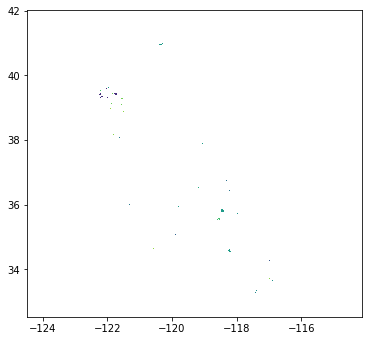

In [82]:
## Visualizing with matplotlib
fig, ax = plt.subplots(figsize = (6, 6))
ax.imshow(band, extent=extent)

Geotiff we used in this project can be used to get day-by-day fire information. As is shown in this image, only where it has a value, it got burned. 

This image shows day of burn information (refer to google slides 'data_information' for more detail). 

### Geotiff to Geojson (Optional)

In [194]:
def geotiff_to_geojson(file):
    """
    input: geotiff
    output: geojson
    """
    
    # Read the dataset's valid data mask as a ndarray.
    mask = file.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rio.features.shapes(
            mask, transform=file.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rio.warp.transform_geom(
            file.crs, 'EPSG:4326', geom, precision=6)
        
        return geom
    

### Load geotiff with xarray

In [16]:
from datetime import datetime as dt

In [71]:
gtif_files = glob.glob('/data_drive/fire_topdown/MODIS/NDVI_4326/2010_1_*.tif')
gtif_files.sort()
print(gtif_files)

def open_gtif(file):
    f_name = file.split('/')[-1].split('.')[0]
    day = dt.strptime(f_name, '%Y_%m_%d')

    with xr.open_rasterio(file) as ff:
        ndvi = ff.load()
    ## suggest you print ndvi and get familar with its coords, attributes and dims
    # print(ndvi)
    
    ## rename ndvi 'band' coordinate to 'day'
    ndvi = ndvi.rename({'band': 'day', 'y': 'lat', 'x': 'lon'})
    
    ## replace band 1 by day
    ndvi['day'].data = [day]

    return ndvi

['/data_drive/fire_topdown/MODIS/NDVI_4326/2010_1_14.tif', '/data_drive/fire_topdown/MODIS/NDVI_4326/2010_1_21.tif', '/data_drive/fire_topdown/MODIS/NDVI_4326/2010_1_28.tif', '/data_drive/fire_topdown/MODIS/NDVI_4326/2010_1_7.tif']


### Concat multiple files

In [74]:
monthly_ndvi_ds = xr.concat([open_gtif(f) for f in gtif_files], dim='day').sortby('day')

In [87]:
monthly_ndvi_ds

<xarray.DataArray (day: 4, lat: 2250, lon: 2316)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 

### Save combined file to netcdf

#### <font color='red'>Note:</font> encoding in this way seems can increase the writing speed and save space

In [96]:
out_dir = '/data_drive/fire_topdown/'
name = 'ndiv'
comp = dict(dtype='int16', scale_factor=1.0, _FillValue=-9999)
ds = monthly_ndvi_ds.to_dataset(name='ndvi')
encoding = {var: comp for var in ds.data_vars} 
ds.to_netcdf(os.path.join(out_dir, name), encoding=encoding)

## Parallel For Loop in Python

In [79]:
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm

In [81]:
## An example

num_cores = multiprocessing.cpu_count()

## tqdm is not necessary. If you don't want the progress bar, inputs = gtif_files
inputs = tqdm(gtif_files) 

files = Parallel(n_jobs=num_cores)(delayed(open_gtif)(i) for i in inputs)

In [82]:
files ## a list of opened dataarray

[<xarray.DataArray (day: 1, lat: 2250, lon: 2316)>
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
 Coordinates:
   * day      (day) datetime64[ns] 2010-01-14
   * lat      (lat) float64 42.1 42.1 42.09 42.09 42.08 ... 32.01 32.01 32.0 32.0
   * lon      (lon) float64 -124.6 -124.6 -124.6 -124.6 ... -114.2 -114.2 -114.2
 Attributes:
     transform:      (0.004491576420597608, 0.0, -124.60082148379823, 0.0, -0....
     crs:            +init=epsg:4326
     res:            (0.004491576420597608, 0.004491576420597608)
     is_tiled:       0
     nodatavals:     (nan,)
     scales:         (1.0,)
     offsets:        (0.0,)
     AREA_OR_POINT:  Area, <xarray.DataArray (day: 1, lat: 2250, lon: 2316)>
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0.

## Shapefile

In [63]:
## example data
shp_file = '../fire-proj/scimap/data/shapefile/ca.shp'

In [70]:
shp = gpd.read_file(shp_file)

In [71]:
## geopandas load shapefile into a table of attributes
with pd.option_context("display.max_rows", 4):
    display(shp)

,fire_ID,lat,lon,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_,landcover,landcover_,tile_ID,year,geometry
0,12,41.9062,-122.959,7.72,17.59,2016-08-31,244,2016-09-12,256,13,0.59,1.28,1.37,3,east,1,Evergreen Needleleaf forest,h08v04,2016,"POLYGON ((-122.99102 41.93333, -122.97421 41.9..."
1,8,41.8937,-122.974,20.37,40.74,2016-08-28,241,2016-09-12,256,16,1.27,2.66,1.49,8,northwest,1,Evergreen Needleleaf forest,h08v04,2016,"POLYGON ((-123.02535 41.92500, -123.01975 41.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4888,10562,41.6979,-120.170,0.21,1.85,2005-08-26,238,2005-08-26,238,1,0.21,0.46,0.46,0,none,0,Water,h09v04,2005,"POLYGON ((-120.17758 41.70000, -120.17200 41.7..."
4889,10567,41.6854,-120.186,1.07,4.63,2005-08-17,229,2005-08-25,237,9,0.12,0.26,0.65,1,north,0,Water,h09v04,2005,"POLYGON ((-120.19548 41.69167, -120.18433 41.6..."


This file has individual fire information. Included attributes are shown in column names. Each row represents a fire. There are 4890 individual fires in CA from 2003-2016

In [75]:
## geopandas selection (select year=2010)
shp_selected = shp[shp.loc[:, 'year'] == 2010]

In [77]:
with pd.option_context('display.max_rows', 4):
    display(shp_selected)

,fire_ID,lat,lon,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_,landcover,landcover_,tile_ID,year,geometry
565,29,41.8854,-122.706,0.86,4.63,2010-08-01,213,2010-08-04,216,4,0.21,0.46,0.53,8,northwest,8,Woody savannas,h08v04,2010,"POLYGON ((-122.72605 41.89167, -122.71485 41.8..."
566,30,41.6646,-121.821,0.21,1.85,2010-09-11,254,2010-09-11,254,1,0.21,0.46,0.46,0,none,12,Croplands,h08v04,2010,"POLYGON ((-121.83326 41.66667, -121.82768 41.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,6888,41.7146,-120.168,0.21,1.85,2010-07-13,194,2010-07-13,194,1,0.21,0.46,0.46,0,none,16,Barren or sparsely vegetated,h09v04,2010,"POLYGON ((-120.17524 41.71667, -120.16966 41.7..."
838,6900,41.5354,-120.185,0.43,2.78,2010-09-03,246,2010-09-03,246,1,0.43,0.93,0.46,0,none,10,Grasslands,h09v04,2010,"POLYGON ((-120.19243 41.53750, -120.18130 41.5..."


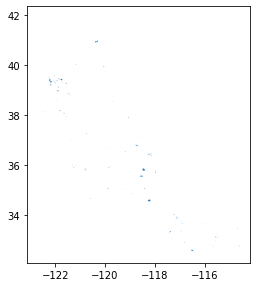

In [94]:
## visualizing CA fires in 2010 
#(make sure you have 'descartes' installed: pip install descartes)

fig, ax = plt.subplots(figsize=(4, 6))
shp_selected.plot(ax=ax)

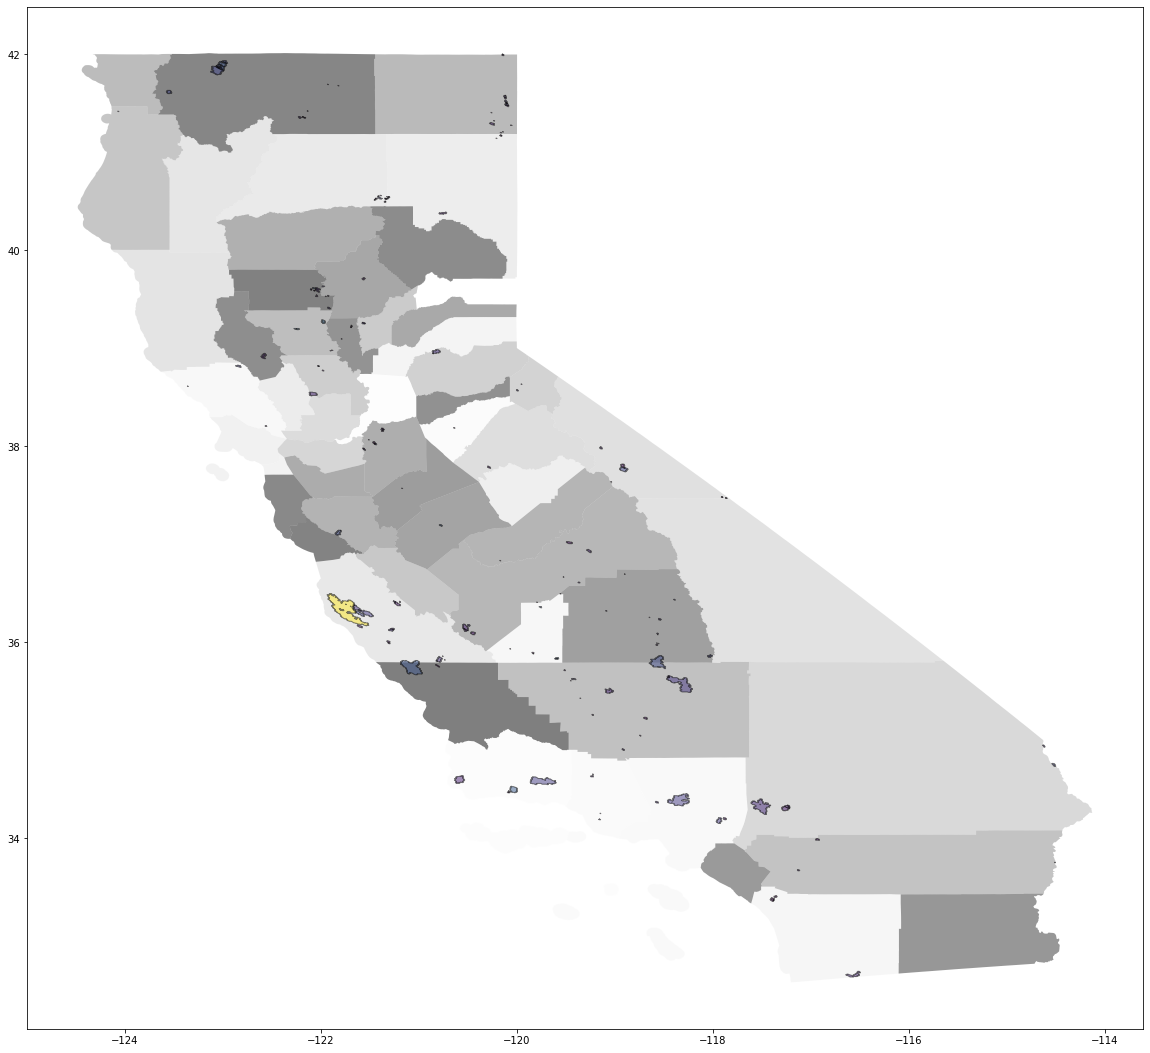

In [206]:
## If overlay with CA map 
# Just give you a sense how it looks like. Data is actually not in 2010, but 2003

fig, ax = plt.subplots(figsize = (20, 20))
ca.plot(ax = ax, cmap = 'Greys', alpha = 0.5)
clip_poly.plot(ax = ax, column = 'duration', alpha=0.5, edgecolor='k')

#### Geopandas to geojson (two different ways)

In [219]:
perimeter_json = clip_poly.__geo_interface__

In [222]:
perimeter_json = clip_poly.to_json()

#### 